# Dataset image, sketch pairs.

In [1]:
import os
import json
import glob
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import inspect
import logging
import math
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import imageio.v3 as imageio
from tqdm.auto import tqdm
from torch.utils.data import random_split




from transformers import CLIPTextModel, CLIPTokenizer, CLIPImageProcessor

import wandb
import diffusers
import transformers
from diffusers import (
    AutoencoderKL,
    ControlNetModel,
    DDIMScheduler,
    UNet2DConditionModel,
)


2025-08-10 22:15:26.959708: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754864127.141291      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754864127.190772      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


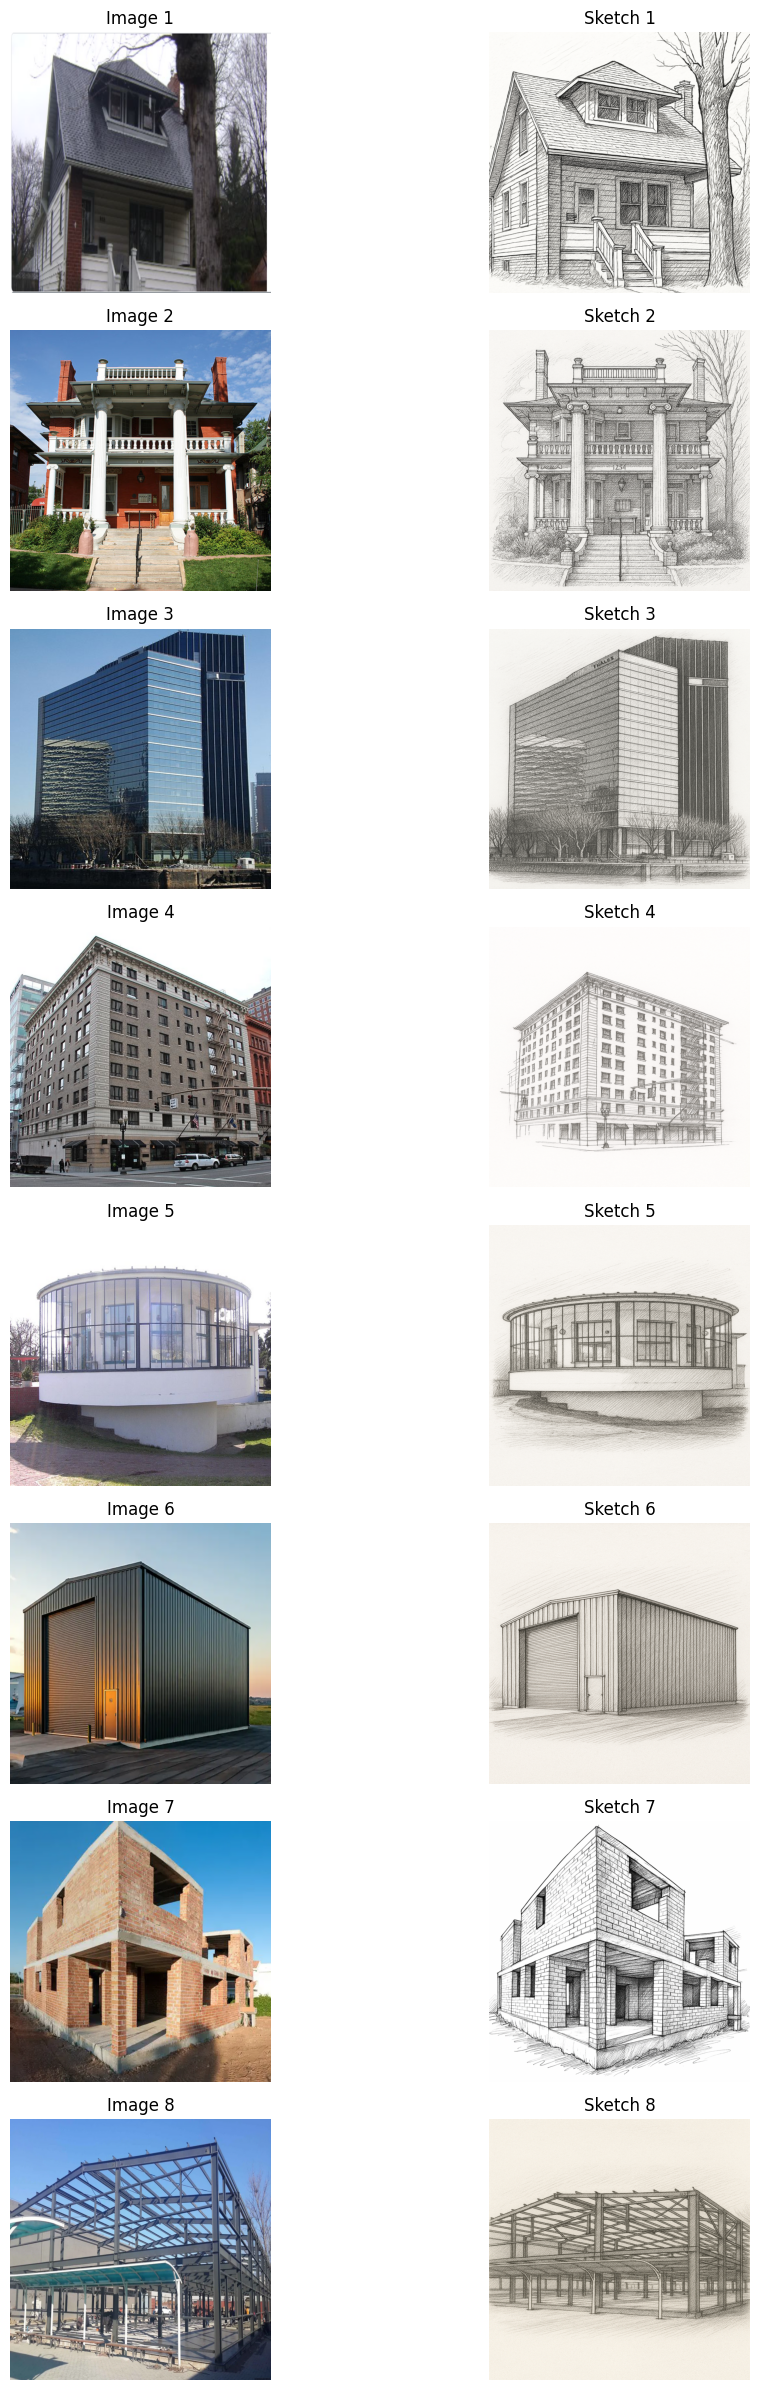

In [2]:

image_path = '/kaggle/input/sketch-2-image-dataset/construction_sketch_dataset/construction_sketch_dataset/Images'
sketch_path = '/kaggle/input/sketch-2-image-dataset/construction_sketch_dataset/construction_sketch_dataset/Sketches'
num_pairs = 8
image_size = (1000, 1000)  # Resize images to a fixed size

# Set grid layout
cols = 2
rows = (num_pairs + cols - 1) // cols  # Auto-calculate rows

plt.figure(figsize=(cols * 6, rows * 6))

for i in range(1, num_pairs + 1):
    img = os.path.join(image_path, f'image_{i}.png')
    sketch = os.path.join(sketch_path, f'sketch_{i}.png')

    # Open and resize
    img = Image.open(img).resize(image_size)
    sketch = Image.open(sketch).resize(image_size)

    # Plot image
    plt.subplot(rows * 2, cols, (i - 1) * 2 + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Image {i}')

    # Plot sketch
    plt.subplot(rows * 2, cols, (i - 1) * 2 + 2)
    plt.imshow(sketch, cmap='gray')
    plt.axis('off')
    plt.title(f'Sketch {i}')

plt.tight_layout()
plt.show()

# Dataloader

In [2]:
class LoRADataset(Dataset):
    def __init__(self, root, prompt_json_path='/kaggle/input/sketch-2-image-dataset/prompts.json', default_prompt="", split="train", length=None, transform=None):
        self.dir = os.path.join(root, split)
        self.img_names = os.listdir(os.path.join(self.dir, "Images"))
        self.default_prompt = default_prompt
        self.transform = transform

        # Load prompts from JSON
        self.prompt_dict = {}
        if prompt_json_path and os.path.exists(prompt_json_path):
            with open(prompt_json_path, "r") as f:
                prompts = json.load(f)
                self.prompt_dict = {item["image"]: item["prompt"] for item in prompts}

        np.random.shuffle(self.img_names)
        if length:
            self.img_names = self.img_names[:length]

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]

        # Load target image
        target_path = os.path.join(self.dir, "Images", img_name)
        target_img = imageio.imread(target_path)[:,:,:3]
        target_img = target_img.astype(np.float32) / 127.5 - 1.0
        target_img = torch.from_numpy(target_img).permute(2, 0, 1)

        # Load sketch image
        sketch_name = img_name.replace("image", "sketch")
        sketch_path = os.path.join(self.dir, "Sketches", sketch_name)
        if not os.path.exists(sketch_path):
            raise FileNotFoundError(f"Sketch not found for image {img_name}: {sketch_path}")

        sketch_img = imageio.imread(sketch_path)
        sketch_img = sketch_img.astype(np.float32) / 255.0
        sketch_img = torch.from_numpy(sketch_img).permute(2, 0, 1)

        # Get prompt from JSON or fallback to default
        prompt = self.prompt_dict.get(img_name, self.default_prompt)
        if not prompt:
            prompt = self.default_prompt  # fallback if prompt is empty string

        if self.transform:
            target_img = self.transform(target_img)
            sketch_img = self.transform(sketch_img)

        return {
            "image": target_img,
            "hint": sketch_img,
            "prompt": prompt
        }



# LoRA

In [ ]:
class LoRALinear(nn.Module):
    """
    LoRA-augmented linear layer for parameter-efficient fine-tuning.

    This wraps an existing nn.Linear layer, freezing its original weights
    and adding a trainable low-rank update using two matrices (lora_A and lora_B).

    The update is computed as:
        ΔW = (lora_B @ lora_A) * (alpha / rank)

    During the forward pass:
        output = original(x) + ΔW(x)

    Args:
        original_linear (nn.Linear):
            The pretrained linear layer to augment with LoRA.
        rank (int, optional):
            The rank 'r' of the low-rank approximation. Defaults to 512.
        alpha (float, optional):
            Scaling factor for the LoRA update. Defaults to 1.0.
    """

    def __init__(self, original_linear: nn.Linear, rank: int = 512, alpha: float = 1.0) -> None:
        super().__init__()

        if not isinstance(original_linear, nn.Linear):
            raise TypeError(
                f"LoRALinear only supports nn.Linear, but got: {type(original_linear)}"
            )

        self.original: nn.Linear = original_linear
        self.rank: int = rank
        self.alpha: float = alpha
        self.scaling: float = alpha / rank

        in_features = original_linear.in_features
        out_features = original_linear.out_features

        # LoRA trainable parameters
        self.lora_A = nn.Parameter(torch.randn(rank, in_features) * 0.01)
        self.lora_B = nn.Parameter(torch.randn(out_features, rank) * 0.01)

        # Freeze original parameters
        for param in self.original.parameters():
            param.requires_grad = False

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward Method.
        Args:
            x (torch.Tensor):
                Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor:
                Output tensor of shape (batch_size, out_features).
        """
        return self.original(x) + self.scaling * (x @ self.lora_A.T @ self.lora_B.T)



def init_lora_attn(model: nn.Module, lora_rank: int = 512, alpha: float = 1.0) -> nn.ModuleList:
    """
    Wraps LoRA adapters around attention projection layers in a model and makes them trainable.

    This function:
    1. Freezes all original model parameters.
    2. Finds attention modules whose names end in 'attn1' or 'attn2'.
    3. Replaces their projection layers (`to_q`, `to_k`, `to_v`,
       and the first `to_out` layer) with LoRA-augmented versions.

    Args:
        model (nn.Module):
            The base model containing attention modules.
        lora_rank (int, optional):
            Rank of the LoRA decomposition. Defaults to 512.
        alpha (float, optional):
            Scaling factor for LoRA updates. Defaults to 1.0.

    Returns:
        nn.ModuleList:
            List of all LoRA layers injected into the model.
    """
    lora_layers = nn.ModuleList()

    # Safety Check: freeze everything first so base weights never train accidentally
    for param in model.parameters():
        param.requires_grad = False

    for name, module in model.named_modules():
        if name.endswith("attn1") or name.endswith("attn2"):
            attn = module

            # Wrap projections: to_q, to_k, to_v
            for proj_name in ['to_q', 'to_k', 'to_v']:
                orig_layer = getattr(attn, proj_name)
                lora_layer = LoRALinear(orig_layer, rank=lora_rank, alpha=alpha)
                setattr(attn, proj_name, lora_layer)
                lora_layers.append(lora_layer)

            # Wrap to_out[0] if it's a list or sequential - case with diffusers 
            if isinstance(attn.to_out, (nn.ModuleList, nn.Sequential)):
                orig_out = attn.to_out[0]
                lora_out = LoRALinear(orig_out, rank=lora_rank, alpha=alpha)
                attn.to_out[0] = lora_out
                lora_layers.append(lora_out)

    # Unfreezes both W0 and del W0. Remove this part for conventional LoRA finetuning.
    for lora_layer in lora_layers.values():
        for param in lora_layer.parameters():
            param.requires_grad = True

    return lora_layers

# Single Image Inference Pipeline

In [5]:
def preprocess_controlnet_image(image: Image.Image, device, dtype=torch.float32):
    image = image.resize((512, 512))
    img_array = np.array(image).astype(np.float32) / 255.0  # normalize to [0,1]
    
    if img_array.ndim == 2:  # Grayscale
        img_array = img_array[None, None, :, :]
    elif img_array.shape[2] == 3:  # RGB
        img_array = img_array.transpose(2, 0, 1)[None, :, :, :]
    else:
        raise ValueError("Unexpected image shape.")

    return torch.tensor(img_array, device=device, dtype=dtype)

def encode_prompt(prompt: str, tokenizer, text_encoder, device):
    inputs = tokenizer(
        [prompt],
        padding="max_length",
        max_length=tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt"
    )
    input_ids = inputs.input_ids.to(device)
    attention_mask = inputs.attention_mask.to(device)

    with torch.no_grad():
        return text_encoder(input_ids, attention_mask=attention_mask).last_hidden_state

@torch.no_grad()
def run_controlnet_inference(
    prompt: str,
    control_image: Image.Image,
    noise_scheduler,
    tokenizer,
    text_encoder,
    vae,
    unet,
    controlnet,
    num_inference_steps=50,
    guidance_scale=7.5,
    device=None,
    weight_dtype=torch.float32
):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")

    # Optionally inject LoRA weights
    

    # Encode prompt
    cond_embeds = encode_prompt(prompt, tokenizer, text_encoder, device)
    uncond_embeds = encode_prompt("", tokenizer, text_encoder, device)
    prompt_embeds = torch.cat([uncond_embeds, cond_embeds], dim=0)

    # Preprocess controlnet image
    controlnet_image = preprocess_controlnet_image(control_image, device=device, dtype=weight_dtype)
    controlnet_image = torch.cat([controlnet_image, controlnet_image], dim=0)  # guidance duplication

    # Prepare latents
    batch_size = 1
    latent_shape = (batch_size, unet.in_channels, 64, 64)
    latents = torch.randn(latent_shape, device=device, dtype=weight_dtype) * noise_scheduler.init_noise_sigma

    noise_scheduler.set_timesteps(num_inference_steps)

    for t in noise_scheduler.timesteps:
        latent_input = torch.cat([latents] * 2)
        latent_input = noise_scheduler.scale_model_input(latent_input, t)

        # ControlNet forward
        down_block_res_samples, mid_block_res_sample = controlnet(
            latent_input,
            t,
            encoder_hidden_states=prompt_embeds,
            controlnet_cond=controlnet_image,
            return_dict=False,
        )

        # UNet forward
        noise_pred = unet(
            latent_input,
            t,
            encoder_hidden_states=prompt_embeds,
            down_block_additional_residuals=[res.to(dtype=weight_dtype) for res in down_block_res_samples],
            mid_block_additional_residual=mid_block_res_sample.to(dtype=weight_dtype),
            return_dict=False,
        )[0]

        # CFG
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # Latent update
        latents = noise_scheduler.step(noise_pred, t, latents).prev_sample

    # Decode latents
    latents = 1 / 0.18215 * latents
    image = vae.decode(latents).sample

    # Postprocess
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.cpu().permute(0, 2, 3, 1).numpy()[0]
    image = (image * 255).round().astype("uint8")
    return Image.fromarray(image)


def show_image(image: Image.Image, title: str = None, figsize=(6, 6)):
    plt.figure(figsize=figsize)
    plt.imshow(image)
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()

# LoRA Finetuning

In [6]:
@torch.no_grad()
def get_input(batch, encode_image=True, encode_prompt=True):
    """
    batch keys:
    - 'hint': condition images (depth maps), normalized [0,1], shape (B, H, W, C)
    - 'image': ground truth images, normalized [-1,1], shape (B, H, W, C)
    - 'prompt': string or list of strings (length B)
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    B = batch['image'].shape[0]

    x = batch['image']
    if x.shape[-1] == 3:
        x = rearrange(x, 'b h w c -> b c h w')
    x = x.to(device=device, memory_format=torch.contiguous_format)

    if encode_image:
        # Encode to latent space, move batch["image"] to device and dtype
        x = vae.encode(batch["image"].to(device=device, dtype=weight_dtype)).latent_dist.sample()
        x = x * vae.config.scaling_factor

    controlnet_image = batch["hint"].to(device=device, dtype=weight_dtype)
    
    prompt = batch['prompt']
    if isinstance(prompt, str):
        prompt = [prompt] * B
    elif isinstance(prompt, list):
        assert len(prompt) == B, "The length of prompt list should equal to batch size!"

    if encode_prompt:
        text_inputs = tokenizer(
            prompt,
            padding="max_length",
            max_length=tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        )
        text_input_ids = text_inputs.input_ids.to(device=device)

        untruncated_ids = tokenizer(prompt, padding="longest", return_tensors="pt").input_ids.to(device=device)

        if untruncated_ids.shape[-1] >= text_input_ids.shape[-1] and not torch.equal(
            text_input_ids, untruncated_ids
        ):
            removed_text = tokenizer.batch_decode(
                untruncated_ids[:, tokenizer.model_max_length - 1 : -1]
            )
            logger.warning(
                "The following part of your input was truncated because CLIP can only handle sequences up to"
                f" {tokenizer.model_max_length} tokens: {removed_text}"
            )

        if hasattr(text_encoder.config, "use_attention_mask") and text_encoder.config.use_attention_mask:
            attention_mask = text_inputs.attention_mask.to(device=device)
        else:
            attention_mask = None

        prompt = text_encoder(
            text_input_ids,
            attention_mask=attention_mask,
        )
        prompt = prompt[0]

        prompt = prompt.to(dtype=text_encoder.dtype, device=device)

    return x, controlnet_image, prompt


In [16]:
data_root = "/kaggle/input/sketch-2-image-dataset/construction_sketch_dataset/construction_sketch_dataset"
guide_prompts = "/kaggle/input/sketch-2-image-dataset/prompts.json"
exp_name = "lora_finetuning_only_cnet_v1"
mode = "lora"
num_images_to_train = 32
pretrained_model_path = "runwayml/stable-diffusion-v1-5"
controlnet_model_path = "lllyasviel/sd-controlnet-canny"
lora_rank = 512
output_dir = "./output"
seed = 0
learning_rate = 6e-5
train_batch_size = 4
max_train_steps = 2000
adam_beta1 = 0.9
adam_beta2 = 0.999
adam_weight_decay = 1e-3
adam_epsilon = 1e-8
max_grad_norm = 1.0
lr_scheduler = "constant"
lr_warmup_steps = 0
gradient_accumulation_steps =1

In [8]:

# Set up output directory
output_dir = os.path.join(output_dir, exp_name)

# Configure logging
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO,
)
logger = logging.getLogger(__name__)
logger.info("Starting training...")

# Set verbosity levels (assuming single process)
transformers.utils.logging.set_verbosity_warning()
diffusers.utils.logging.set_verbosity_info()

# Set the seed if provided
from transformers import set_seed
if seed is not None:
    set_seed(seed)

# Handle output directory creation
os.makedirs(output_dir, exist_ok=True)
# os.makedirs(f"{output_dir}/validation", exist_ok=True)
os.makedirs(f"{output_dir}/pretrained", exist_ok=True)


# Load Models

In [ ]:


# Load scheduler, tokenizer and models.
noise_scheduler = DDIMScheduler.from_pretrained(pretrained_model_path, subfolder="scheduler")
tokenizer = CLIPTokenizer.from_pretrained(pretrained_model_path, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(pretrained_model_path, subfolder="text_encoder")
vae = AutoencoderKL.from_pretrained(pretrained_model_path, subfolder="vae")
unet = UNet2DConditionModel.from_pretrained(pretrained_model_path, subfolder="unet")
controlnet = ControlNetModel.from_pretrained(controlnet_model_path)

# Freeze vae, unet and text_encoder
vae.requires_grad_(False)
text_encoder.requires_grad_(False)
unet.requires_grad_(False)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Set weight dtype
weight_dtype = torch.float32



# Move models to device with specified dtype
text_encoder.to(device, dtype=weight_dtype)
vae.to(device, dtype=weight_dtype)
unet.to(device, dtype=weight_dtype)

In [18]:

lora_layers = init_lora_attn(controlnet, lora_rank=512)


optimizer = torch.optim.AdamW(
    [p for layer in lora_layers for p in layer.parameters() if p.requires_grad],
    lr=learning_rate,
    betas=(adam_beta1, adam_beta2),
    weight_decay=adam_weight_decay,
    eps=adam_epsilon
)


seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

transform = transforms.Compose([
    transforms.Resize((512, 512))
])

# Load the full dataset (all images, no explicit split folder)
full_dataset = LoRADataset(
    root=data_root,
    split="",       # loads from root/Images and root/Sketches
    transform=transform
)

# Define deterministic split sizes
train_size = int(0.95 * len(full_dataset))
val_size = len(full_dataset) - train_size

# Perform deterministic random split
train_dataset, val_dataset = random_split(
    full_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(seed)
)

# Dataloaders
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=train_batch_size, shuffle=True
)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=1, shuffle=False
)


# Scheduler

from diffusers.optimization import get_scheduler

lr_scheduler = get_scheduler(
    'cosine',
    optimizer=optimizer,
    num_warmup_steps=lr_warmup_steps * gradient_accumulation_steps,
    num_training_steps=max_train_steps * gradient_accumulation_steps,
)



# We need to recalculate our total training steps as the size of the training dataloader may have changed.
num_update_steps_per_epoch = math.ceil(len(train_dataloader) / gradient_accumulation_steps)
# Afterwards we recalculate our number of training epochs
num_train_epochs = math.ceil(max_train_steps / num_update_steps_per_epoch)



In [ ]:

print(f"Number of trainable parameters in ControlNet: { sum(p.numel() for p in controlnet.parameters() if p.requires_grad)}")
print(f"Number of training samples: {len(train_dataset)}")


# Main Training Loop

In [ ]:
fixed_image = Image.open("/kaggle/input/val-image/whereness assignment sketch.png")

In [ ]:
controlnet.to(device = device)
controlnet.train()
global_step = 0
first_epoch = 0

best_loss = float('inf')
best_epoch_weights = None

for epoch in range(first_epoch, num_train_epochs):
    epoch_loss = 0.0
    steps_in_epoch = len(train_dataloader) // gradient_accumulation_steps
    progress_bar = tqdm(range(steps_in_epoch), desc=f"Epoch {epoch+1}/{num_train_epochs}")

    for step, batch in enumerate(train_dataloader):
        with torch.set_grad_enabled(True):
            x, controlnet_image, prompt_embed = get_input(batch)
            t = torch.randint(
                0,
                noise_scheduler.config.num_train_timesteps,
                (x.shape[0],),
                device=device
            ).long()

            noise = torch.randn_like(x)
            x_noisy = noise_scheduler.add_noise(x, noise, t)

            if noise_scheduler.config.prediction_type == "epsilon":
                target = noise
            elif noise_scheduler.config.prediction_type == "v_prediction":
                target = noise_scheduler.get_velocity(x, noise, t)
            else:
                raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")

            down_block_res_samples, mid_block_res_sample = controlnet(
                x_noisy,
                t,
                encoder_hidden_states=prompt_embed,
                controlnet_cond=controlnet_image,
                return_dict=False,
            )

            model_pred = unet(
                x_noisy,
                t,
                encoder_hidden_states=prompt_embed,
                down_block_additional_residuals=[
                    sample.to(dtype=weight_dtype) for sample in down_block_res_samples
                ],
                mid_block_additional_residual=mid_block_res_sample.to(dtype=weight_dtype),
                return_dict=False,
            )[0]

            loss = F.mse_loss(model_pred.float(), target.float(), reduction="mean")
            loss = loss / gradient_accumulation_steps

            loss.backward()
            epoch_loss += loss.item()

            if (step + 1) % gradient_accumulation_steps == 0:
                torch.nn.utils.clip_grad_norm_(lora_layers.parameters(), max_grad_norm)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

                progress_bar.update(1)
                global_step += 1

                logs = {
                    "step_loss": loss.detach().item(),
                    "lr": lr_scheduler.get_last_lr()[0]
                }
                progress_bar.set_postfix(**logs)

        if global_step >= max_train_steps:
            break

    # Average loss for the epoch
    avg_epoch_loss = epoch_loss / (steps_in_epoch)
    controlnet_save_path = f"./best_controlnet_{avg_epoch_loss}.pth"
    print(f"Epoch {epoch+1} average loss: {avg_epoch_loss:.4f}")

    if avg_epoch_loss <= 0.09888:
        best_loss = avg_epoch_loss
        print(f"Low loss: {best_loss:.4f} — saving full ControlNet weights to {controlnet_save_path}")
        torch.save(controlnet.state_dict(), controlnet_save_path)

    if (epoch+1) % 10 == 0:
        controlnet.eval()
        with torch.no_grad():
            generated_image = run_controlnet_inference(
                prompt="Rectangular Structure House with flat roof",
                control_image=fixed_image,
                noise_scheduler=noise_scheduler,
                tokenizer=tokenizer,
                text_encoder=text_encoder,
                vae=vae,
                unet=unet,
                controlnet=controlnet,
                device=device,
                weight_dtype=weight_dtype,
                inject_lora=False
            )
            show_image(generated_image, title=f"Inference at Epoch {epoch+1}")
            show_images_side_by_side(
            [fixed_image, generated_image],
            titles=[f"Fixed Control Image", f"Generation after Epoch {epoch+1}"]
        )
        controlnet.train()


progress_bar.close()
